In [1]:
using JuMP, GLPK
using DataFrames
using CSV
using PrettyTables
using Random
using Plots

In [31]:
scenarios_df = CSV.read("load_profiles.csv", DataFrame)
n_scenarios = size(scenarios_df, 2)
M = 10000
in_sample_n = 50

50

# Task 2.1

In [3]:
#define function
function also_x_loop(q)
    # Create a new model with GLPK solver
    model = Model(GLPK.Optimizer)

    @variable(model, cap_bid)
    @variable(model, bin_var[1:60, 1:in_sample_n])

    @constraint(model, cap_bid >= 0)


    for scenario in 1:in_sample_n
        for minute in 1:60
            @constraint(model, cap_bid - scenarios_df[minute, scenario] <= M * bin_var[minute, scenario])
            @constraint(model, bin_var[minute, scenario] <= 1)
            @constraint(model, bin_var[minute, scenario] >= 0)
        end
    end
    @constraint(model, sum(bin_var[minute, scenario] for scenario in 1:in_sample_n, minute in 1:60) <= q)

    # Define the objective function
    @objective(model, Max, cap_bid)

    # Solve the model
    optimize!(model)

    # Check the status of the solution
    status = termination_status(model)
    if status == MOI.OPTIMAL
        #println("Optimal solution found")
        #println("Optimal solution cap_bid by also_x: ", value(cap_bid))
    elseif status == MOI.INFEASIBLE
        println("No feasible solution found")
    else
        println("Solver status: ", status)
    end
    return JuMP.value.(bin_var), JuMP.value(cap_bid)
end

function also_x_function(p_value)

    stopping_parameter = 0.0001

    lwr_q = 0
    upr_q = (1-p_value)*in_sample_n*60
    counter = 0

    while upr_q - lwr_q >= stopping_parameter
        q = (lwr_q + upr_q)/2
        bin_var, cap_bid = also_x_loop(q)
        num_zeros = count(x -> x == 0, bin_var)
        #println("q: ", q, " num_zeros: ", num_zeros)

        if num_zeros/length(bin_var) >= p_value
            lwr_q = q
        else
            upr_q = q
        end

        if upr_q - lwr_q < stopping_parameter
            #println("q: ", q, " num_zeros: ", num_zeros)
            println("Optimal solution cap_bid by Also_X: ", value(cap_bid))
            return cap_bid
        end

        # if counter > 100
        #     #println("q: ", q, " num_zeros: ", num_zeros)
        #     println("Optimal solution cap_bid by Also_X: ", value(cap_bid))
        #     return cap_bid
        # end
        counter += 1
    end
end

also_x_function (generic function with 1 method)

In [4]:
function cvar_function(p_value)
    # Create a new model with GLPK solver
    model = Model(GLPK.Optimizer)

    @variable(model, cap_bid)
    @variable(model, beta <= 0)
    @variable(model, theta[1:60, 1:in_sample_n])

    @constraint(model, cap_bid >= 0)

    for scenario in 1:in_sample_n
        for minute in 1:60
            @constraint(model, cap_bid - scenarios_df[minute, scenario] <= theta[minute, scenario])
            @constraint(model, beta <= theta[minute, scenario])
        end
    end
    @constraint(model, (1/(60*in_sample_n))*sum(theta[minute, scenario] for scenario in 1:in_sample_n, minute in 1:60) <= p_value*beta) 

    # Define the objective function
    @objective(model, Max, cap_bid)

    # Solve the model
    optimize!(model)

    # Check the status of the solution
    status = termination_status(model)
    if status == MOI.OPTIMAL
        #println("Optimal solution found")
        println("Optimal solution cap_bid by C_Var: ", value(cap_bid))
    elseif status == MOI.INFEASIBLE
        println("No feasible solution found")
    else
        println("Solver status: ", status)
    end

    return value(cap_bid)
end

cvar_function (generic function with 1 method)

In [5]:
p_value = 0.9
also_x_value = also_x_function(p_value)
cvar_value = cvar_function(p_value)

Optimal solution cap_bid by Also_X: 300.0
Optimal solution cap_bid by C_Var: 296.4980071934071


296.4980071934071

# Task 2.2

In [35]:
function in_sample_test(p_value, cvar_value, also_x_value)
    below_cvar = 0
    below_also_x = 0

    out_sample_n = n_scenarios-in_sample_n

    c_var_shortfall = zeros(60)	
    also_x_shortfall = zeros(60)

    #check how many values are above the cvar_value
    #for i in 1+in_sample_n:n_scenarios
    for i in 1:in_sample_n

        minute_values = scenarios_df[:,i]
        
        for minute in 1:60
            if minute_values[minute] < cvar_value
                #println("Scenario ", i, " minute ", minute, " value ", minute_values[minute])
                c_var_shortfall[minute] += (cvar_value - minute_values[minute])/in_sample_n
            end
            if minute_values[minute] < also_x_value
                #println("Scenario ", i, " minute ", minute, " value ", minute_values[minute])
                also_x_shortfall[minute] += (also_x_value - minute_values[minute])/in_sample_n
            end
        end
        below_cvar += sum(minute_values .< cvar_value)
        below_also_x += sum(minute_values .< also_x_value)
    end

    below_cvar = below_cvar/in_sample_n/60
    below_also_x = below_also_x/in_sample_n/60

    println("Percentage of values below CVaR: ", below_cvar)
    println("Percentage of values below Also_X: ", below_also_x)

    return below_cvar, below_also_x
end

in_sample_test (generic function with 1 method)

In [42]:
function out_sample_test(p_value, cvar_value, also_x_value)
    below_cvar = 0
    below_also_x = 0

    out_sample_n = n_scenarios-in_sample_n

    c_var_shortfall = zeros(60)	
    also_x_shortfall = zeros(60)

    #check how many values are above the cvar_value
    for i in 1+in_sample_n:n_scenarios
    #for i in 1:in_sample_n

        minute_values = scenarios_df[:,i]
        
        for minute in 1:60
            if minute_values[minute] < cvar_value
                #println("Scenario ", i, " minute ", minute, " value ", minute_values[minute])
                c_var_shortfall[minute] += (cvar_value - minute_values[minute])
            end
            if minute_values[minute] < also_x_value
                #println("Scenario ", i, " minute ", minute, " value ", minute_values[minute])
                also_x_shortfall[minute] += (also_x_value - minute_values[minute])
            end
        end
        below_cvar += sum(minute_values .< cvar_value)
        below_also_x += sum(minute_values .< also_x_value)
    end

    below_cvar = below_cvar/out_sample_n/60
    below_also_x = below_also_x/out_sample_n/60

    #sum the shortfalls
    c_var_shortfall = sum(c_var_shortfall)/out_sample_n/60
    also_x_shortfall = sum(also_x_shortfall)/out_sample_n/60

    println("CVaR shortfall: ", c_var_shortfall, " Also_X shortfall: ", also_x_shortfall)

    println("Percentage of values below CVaR: ", below_cvar)
    println("Percentage of values below Also_X: ", below_also_x)

    return below_cvar, below_also_x
end

out_sample_test (generic function with 1 method)

In [43]:
p_value = 0.9
also_x_value = also_x_function(p_value)
cvar_value = cvar_function(p_value)
#in_sample_test(p_value, cvar_value, also_x_value)
out_sample_test(p_value, cvar_value, also_x_value)

Optimal solution cap_bid by Also_X: 321.8061393650475
Optimal solution cap_bid by C_Var: 296.4980071934071
CVaR shortfall: 2.3909599309668716 Also_X shortfall: 4.822477417536566
Percentage of values below CVaR: 0.07111111111111111
Percentage of values below Also_X: 0.12877777777777777


(0.07111111111111111, 0.12877777777777777)

# Task 2.3

In [47]:
p_value_list = [0.75, 0.8, 0.85, 0.9, 0.95, 0.99, 0.99999]
below_cvar_list = []
below_also_x_list = []
also_x_bids = []
cvar_bids = []

for p_value in p_value_list
    also_x_value = also_x_function(p_value)
    cvar_value = cvar_function(p_value)
    below_cvar, below_also_x = out_sample_test(p_value, cvar_value, also_x_value)
    push!(below_cvar_list, below_cvar)
    push!(below_also_x_list, below_also_x)
    push!(also_x_bids, also_x_value)
    push!(cvar_bids, cvar_value)
end

Optimal solution cap_bid by Also_X: 346.0413071233624
Optimal solution cap_bid by C_Var: 320.2742191869674
CVaR shortfall: 4.629555801922582 Also_X shortfall: 9.597381252795197
Percentage of values below CVaR: 0.12355555555555556
Percentage of values below Also_X: 0.27799999999999997
Optimal solution cap_bid by Also_X: 340.4650200209225
Optimal solution cap_bid by C_Var: 314.5286548933596
CVaR shortfall: 3.9696574439667014 Also_X shortfall: 8.151388199614722
Percentage of values below CVaR: 0.1061111111111111
Percentage of values below Also_X: 0.23955555555555555
Optimal solution cap_bid by Also_X: 333.64391520730425
Optimal solution cap_bid by C_Var: 306.9469948124019
CVaR shortfall: 3.2275220210025273 Also_X shortfall: 6.682135842525239
Percentage of values below CVaR: 0.08955555555555555
Percentage of values below Also_X: 0.19144444444444444
Optimal solution cap_bid by Also_X: 321.8061393650475
Optimal solution cap_bid by C_Var: 296.4980071934071
CVaR shortfall: 2.3909599309668716 A

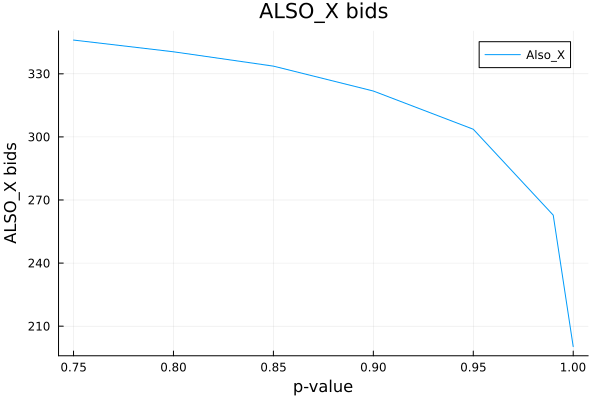

In [50]:
#plot lists
plot(p_value_list, also_x_bids, label="Also_X", xlabel="p-value", ylabel="ALSO_X bids", title="ALSO_X bids")

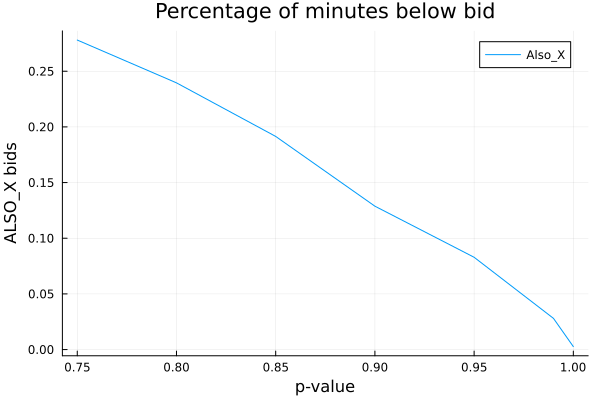

In [52]:
#plot lists
plot(p_value_list, below_also_x_list, label="Also_X", xlabel="p-value", ylabel="ALSO_X bids", title="Percentage of minutes below bid")